# US Media Sentiment Fund

This notebook builds a US media sentiment fund based on news analytics data from Thomson Reuters. The fund selects about 250 liquid stocks with daily news coverage, assigns forecasted alpha as their weights, and rebalances quarterly.

Author: Xin Wei (weixin0127@gmail.com), Indiana University Bloomington  
Version: 2019/12/31

In [22]:
import numpy as np
import pandas as pd
import math
import datetime as dt
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import time

from datetime import timedelta
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

# Display options
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## 1. Import Data

In [23]:
print("Importing data... This may take a few minutes.")
data = pd.read_csv("../Data/processed_data.csv", index_col = 0)
print("Importing data: done!")

Importing data... This may take a few minutes.


/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Importing data: done!


In [24]:
data.head()

,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe,takeSequence,bodySize,companyCount,sentenceCount,wordCount,firstMentionSentence,relevance,sentimentClass,sentimentNegative,sentimentNeutral,sentimentPositive,sentimentWordCount,noveltyCount12H,noveltyCount24H,noveltyCount3D,noveltyCount5D,noveltyCount7D,volumeCounts12H,volumeCounts24H,volumeCounts3D,volumeCounts5D,volumeCounts7D,dummy_ENER,dummy_BMAT,dummy_INDS,dummy_CYCS,dummy_NCYC,dummy_SHOP,dummy_FDRT,dummy_HECA,dummy_FINS,dummy_TECH,dummy_TCOM,dummy_MDIA,dummy_UTIL,dummy_REAL,dummy_RES,dummy_RESF,dummy_RCH,dummy_DIV,dummy_IPO,dummy_MRG,dummy_DEAL1,dummy_BKRT,dummy_CEO1,dummy_LAYOFS,dummy_ACB,dummy_CLJ,dummy_BRIB,dummy_HACK,dummy_FAKE1,dummy_SCAM1,dummy_EMRG,dummy_US,dummy_WEU,dummy_ASIA,dummy_CN,dummy_STX,dummy_DBT,dummy_CDM,dummy_COM,dummy_DRV,dummy_FRX,dummy_GVD,dummy_HOT,dummy_MTG,dummy_PVE,dummy_MUNI,dummy_HEDGE,returnClosePrevMkt1,returnOpenPrevMkt1,returnClosePrevMkt10,returnOpenPrevMkt10,returnsOpenNextMktres90,dayTrend,firstMentionPosition,sentimentCoverage,dollarVolume,liquid
0,2009-07-01,A.N,Agilent Technologies Inc,3392404.0,20.62,20.37,0.015263,-0.004399,0.009137,0.005671,0.121872,0.092225,0.099700,0.076727,-0.007306,1.0,1.0,6143.5,1.5,45.5,1042.5,0.5,0.535714,0.0,0.413971,0.311157,0.274872,841.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,3.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005596,-0.007631,0.019788,0.013947,0.168147,1.012273,0.010989,0.807194,6.910327e+07,1
1,2009-07-01,AAI.N,AirTran Holdings Inc,2028035.0,6.49,6.24,0.048465,0.012987,0.044623,0.020889,0.092593,0.110320,0.078238,0.100866,-0.033102,0.0,1.0,2092.0,1.0,13.0,345.0,1.0,1.000000,1.0,0.038945,0.125715,0.835340,345.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,7.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005596,-0.007631,0.019788,0.013947,-0.506347,1.040064,0.076923,1.000000,1.265494e+07,0
2,2009-07-01,AAP.N,Advance Auto Parts Inc,1521800.0,42.09,41.71,0.014461,0.002162,0.013598,0.003149,-0.000227,0.020769,-0.008369,0.014866,0.063681,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005596,-0.007631,0.019788,0.013947,-0.129324,1.009111,NaN,NaN,6.347428e+07,1
3,2009-07-01,AAPL.O,Apple Inc,14795450.0,142.83,143.52,0.002808,0.006028,0.000718,0.012064,0.053474,0.049813,0.030308,0.034176,0.028540,1.0,1.0,3536.5,4.0,26.0,625.5,0.5,0.525717,0.5,0.170425,0.269772,0.559802,362.0,0.0,0.0,0.0,0.0,0.0,3.5,3.5,28.5,28.5,79.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005596,-0.007631,0.019788,0.013947,0.189275,0.995192,0.019231,0.578737,2.123443e+09,1
4,2009-07-01,AAWW.O,Atlas Air Worldwide Holdings Inc,276289.0,23.88,23.21,0.029754,-0.021913,0.021160,-0.010603,0.054770,0.012653,0.025541,-0.006189,-0.053709,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005596,-0.007631,0.019788,0.013947,0.070404,1.028867,NaN,NaN,6.412668e+06,0


## 2. Construct Media Sentiment Fund

In [25]:
class MediaSentimentFund():
        
    def __init__(self, data):
        """ Pass inputs to class variables
        """
        self.df = data
    
    def get_mkt_predictors(self):
        """ Define and return market data predictors
        """
        mkt_predictors = ['dayTrend', 'volume', 'returnsClosePrevMktres1', 'returnsOpenPrevMktres1']
        return mkt_predictors
    
    def get_all_predictors(self):
        """ Define and return all predictors for market and news data
        """
        dummies = [column for column in self.df.columns if 'dummy_' in column]
        news_predictors = ['sentimentClass', 'sentimentNegative', 'sentimentNeutral', 'sentimentPositive', 
                          'noveltyCount12H', 'noveltyCount24H', 'noveltyCount3D', 'noveltyCount5D', 'noveltyCount7D', 
                          'volumeCounts12H', 'volumeCounts24H', 'volumeCounts3D', 'volumeCounts5D', 'volumeCounts7D',
                          'wordCount', 'companyCount', 'firstMentionPosition', 'sentimentCoverage'] + dummies
        predictors = self.get_mkt_predictors() + news_predictors
        return predictors
    
    def accuracy(self, y_pred, y_actual):
        """ Calculate the accuracy of direction prediction from actual y and predicted y
        """
        return sum(np.sign(y_pred) == np.sign(y_actual)) / len(y_actual)
    
    def information_ratio(self, return_series, horizon):
        """ Calculate annualized information ratio from portfolio return series
        """
        return np.sqrt(252 / horizon) * np.mean(return_series) / np.std(return_series)

    def alpha_weighted_portfolio(self, predictor_cols, horizon, best_params, mkt = False):
        """ Build alpha-weighted portfolio and evaluate performance
        """
        ### Initialization
        if mkt:
            df = self.df
        else:
            # Drop rows that don't have news
            df = self.df[self.df.sentimentPositive.notnull()]
            
        # Define target variable
        target_col = 'returnsOpenNextMktres{}'.format(horizon)
        
        ### Split data into training, validation and test sets
        dates = df['time'].unique()
        # Note: df cuts tail 90 days. Minus 270 to make it consistent with 
        # hyperparameter tuning file that uses data cuts tail 360 days
        test = range(len(dates))[int(0.50*(len(dates) - 270)):]
        # Create a gap between the train/val data and test data, so that we are not "peeking into the future"
        train = range(len(dates))[:int(0.60*(int(0.50*(len(dates) - 270)) - horizon))]
        val = range(len(dates))[int(0.60*(int(0.50*(len(dates) - 270)) - horizon)): int(0.50*(len(dates) - 270)) - horizon]
        # Training data
        X_train = df[predictor_cols].loc[df['time'].isin(dates[train])].values
        Y_train = df[target_col].loc[df['time'].isin(dates[train])].values
        # Validation data
        X_val = df[predictor_cols].loc[df['time'].isin(dates[val])].values
        Y_val = df[target_col].loc[df['time'].isin(dates[val])].values
        # Test data
        X_test = df[['time'] + predictor_cols].loc[df['time'].isin(dates[test])]
        Y_test = df[['time', target_col]].loc[df['time'].isin(dates[test])]


        ### Feature scaling
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_val = sc.transform(X_val)
        X_test[predictor_cols] = sc.transform(X_test[predictor_cols].values)
        
        ### Training LightGBM
        params = {'objective': 'regression',
                  'metric': 'rmse',
                  'num_leaves': best_params['num_leaves'],                # larger for better accuracy
                  'max_depth': -1,                                        # larger for better accuracy. No limit: <0
                  'learning_rate': best_params['learning_rate'],          # smaller for better accuracy
                  'bagging_fraction': best_params['subsample'],           # alias: subsample
                  'feature_fraction': best_params['colsample_bytree'],    # alias: colsample_bytree
                  'bagging_freq': 5,                                      # alias: subsample_freq
                  'bagging_seed': 2018,
                  'verbosity': -1}        

        lgtrain, lgval = lgb.Dataset(X_train, Y_train), lgb.Dataset(X_val, Y_val)

        train_start = time.time()
        lgbmodel = lgb.train(params, lgtrain, 2000, valid_sets=[lgtrain, lgval], early_stopping_rounds=100, verbose_eval=200)
        print("Training LightGBM took %.0f minutes." % math.ceil((time.time() - train_start)/60))
        
        
        ### Prediction & calculate performance
        pred_df_all = df[['time', 'assetCode', target_col, 'liquid']].loc[df['time'].isin(dates[test])]
        Y_pred = np.array([])
        capital = 1000000
        portfolio_total_value = capital
        equity_curve = []
        equity_curve.append(capital)
        daily_alpha_series = []
        daily_unit_weights = pd.DataFrame()
        holdings = []
        day_count = 0

        pred_start = time.time()
        for predday in dates[test]:

            # Calculate unit weights for each day
            x_test = X_test[predictor_cols].loc[X_test['time'] == predday].values
            y_pred = lgbmodel.predict(x_test, num_iteration=lgbmodel.best_iteration)
            Y_pred = np.append(Y_pred, y_pred)
            
            pred_df_daily = pred_df_all[pred_df_all['time'] == predday]
            days_after_rebalance = horizon if day_count % horizon == 0 else day_count % horizon
            pred_df_daily = pred_df_daily.assign(unitWeight = y_pred * pred_df_daily.liquid, days_after_rebalance = days_after_rebalance)
            daily_unit_weights = daily_unit_weights.append(pred_df_daily)

            # Daily update of portfolio value
            if day_count != 0:
                rebalance_code_weights = rebalance_code_weights.merge(self.df[['assetCode', 'returnsOpenPrevRaw1', 'returnsOpenPrevMktres1']]
                                                                      .loc[self.df['time'] == predday], how = 'left', on = 'assetCode').fillna(0)
                updated_open = np.multiply(rebalance_code_weights.open.values, 1 + rebalance_code_weights.returnsOpenPrevRaw1.values)
                rebalance_code_weights['open'] = updated_open
                portfolio_total_value = np.inner(rebalance_code_weights.weight.values, rebalance_code_weights.open.values)
                equity_curve.append(portfolio_total_value)
                
                # Calculate information ratio
                daily_alpha = np.inner(rebalance_code_weights.returnsOpenPrevMktres1.values, rebalance_code_weights.weight.values)
                daily_alpha_series.append(daily_alpha)
                
                rebalance_code_weights = rebalance_code_weights.drop(columns = ['returnsOpenPrevRaw1', 'returnsOpenPrevMktres1'])
            
            # Quarterly rebalance:
            if day_count % horizon == 0:
                holdings.append(sum(pred_df_daily.liquid))
                rebalance_code_weights = daily_unit_weights[['assetCode', 'unitWeight']].groupby('assetCode').agg(
                                                                                                    lambda x: np.average(x, weights = daily_unit_weights.loc[x.index, 'days_after_rebalance'])
                                                                                                        ).reset_index()
                code_open = self.df[['assetCode', 'open']].loc[self.df['time'] == predday]
                rebalance_code_weights = rebalance_code_weights.merge(code_open, how = 'inner', on = 'assetCode').reset_index()
                portfolio_unit_value = np.inner(rebalance_code_weights.unitWeight.values, rebalance_code_weights.open.values)
                portfolio_scale = portfolio_total_value / portfolio_unit_value
                portfolio_weight = np.multiply(portfolio_scale, rebalance_code_weights.unitWeight.values)
                rebalance_code_weights= rebalance_code_weights.assign(weight = portfolio_weight)
                
                # Reset daily_unit_weights
                daily_unit_weights = pd.DataFrame()

            day_count += 1
            
        print('prediction is done!')
        print('prediction took %.0f minutes.' % math.ceil((time.time() - pred_start)/60))
        print('-------------------------')

        ### Report results
        accu = self.accuracy(Y_pred, Y_test[target_col].values)
        print('accuracy of correct sign prediction is: ', accu)
        info_ratio = self.information_ratio(daily_alpha_series, 1)
        print('annualized information ratio is: ', info_ratio)
        
        return (accu, info_ratio, equity_curve, dates[test], holdings)

## 3. Compare Fund Performance

In [26]:
a = MediaSentimentFund(data)

In [27]:
# best parameters obtained from hyperparameter tuning
best_params_all = {'colsample_bytree': 0.65,
 'learning_rate': 0.01,
 'num_leaves': 32,
 'reg_alpha': 0.5,
 'reg_lambda': 0.5,
 'subsample': 0.75
}
best_params_mkt = {'colsample_bytree': 0.65,
 'learning_rate': 0.01,
 'num_leaves': 32,
 'reg_alpha': 0.5,
 'reg_lambda': 0.5,
 'subsample': 0.75
}
# forecasting horizon
horizon = 90

In [28]:
# build alpha-weighted portfolio using both market and news data
(accu_all, ir_all, equity_curve_all, dates_test, holdings_all) = a.alpha_weighted_portfolio(a.get_all_predictors(), horizon, best_params_all)

Training until validation scores don't improve for 100 rounds.
[200]	training's rmse: 0.162745	valid_1's rmse: 0.260585
[400]	training's rmse: 0.161602	valid_1's rmse: 0.260567
Early stopping, best iteration is:
[306]	training's rmse: 0.162085	valid_1's rmse: 0.260524
Training LightGBM took 1 minutes.
prediction is done!
prediction took 12 minutes.
-------------------------
accuracy of correct sign prediction is:  0.5528532606205872
annualized information ratio is:  0.4202624932395392


In [29]:
# build alpha-weighted portfolio using market data
(accu_mkt, ir_mkt, equity_curve_mkt, dates_test, holdings_mkt) = a.alpha_weighted_portfolio(a.get_mkt_predictors(), horizon, best_params_mkt, mkt = True)

Training until validation scores don't improve for 100 rounds.
[200]	training's rmse: 0.177894	valid_1's rmse: 0.244045
Early stopping, best iteration is:
[239]	training's rmse: 0.177826	valid_1's rmse: 0.244037
Training LightGBM took 1 minutes.
prediction is done!
prediction took 12 minutes.
-------------------------
accuracy of correct sign prediction is:  0.5493880847185715
annualized information ratio is:  0.3426131806716467


In [30]:
# import S&P 500 historical data
dates_list = [dt.datetime.strptime(date, "%Y-%m-%d").date() for date in dates_test]
spy = pd.read_csv("../Data/SPY.csv")
spy.Date = pd.to_datetime(spy.Date).apply(lambda x: x.date())
spy = spy[(spy['Date'] >= dates_list[0]) & (spy['Date'] <= dates_list[-1])].reset_index()

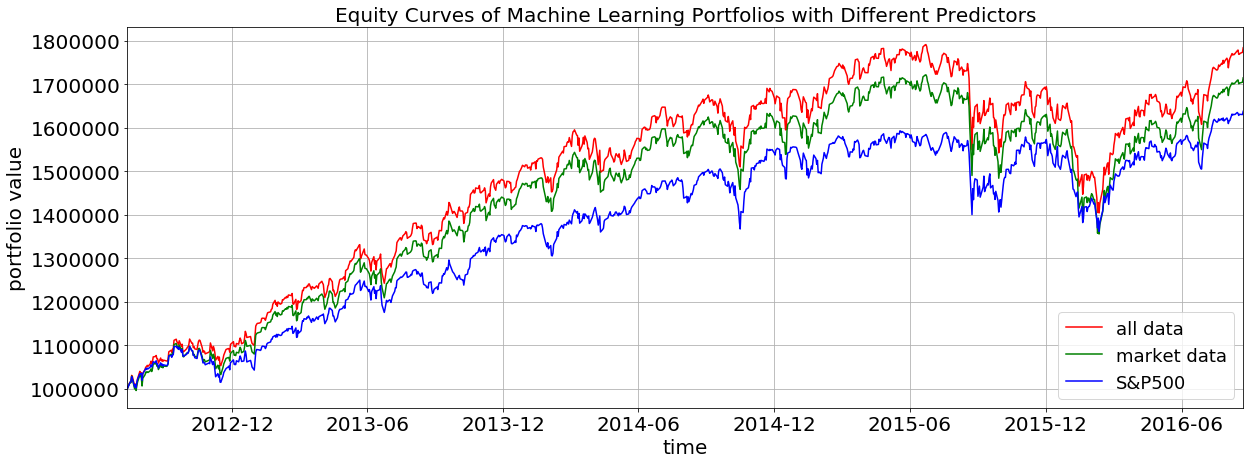

In [31]:
# plot
plt.figure(figsize = (20,7))
plot_all = plt.plot(dates_list, equity_curve_mlw_all, 'r', label = 'all data')
plot_mkt = plt.plot(dates_list, equity_curve_mlw_mkt, 'g', label = 'market data')
plot_spy = plt.plot(dates_list, spy.Open * 1000000 / spy.Open[0], 'b', label = 'S&P500')
plt.ylabel('portfolio value', fontsize = 20)
plt.xlabel('time', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlim('2012-07-13', '2016-08-23')
plt.grid(True)
plt.legend(fontsize = 18, loc = 'lower right')
plt.title('Equity Curves of Machine Learning Portfolios with Different Predictors', fontsize = 20)
plt.show()